# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
# Importing all the necessary libraries to run this project
import pickle
import cv2
from sklearn import preprocessing
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import skimage.transform as skimage_tf
import skimage.exposure as exposure
import skimage.io as sk_io
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import math
import time
import os
import glob
%matplotlib inline                 

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
print('Extracted training pickle data..')
X_test, y_test = test['features'], test['labels']
print('Extracted test pickle data..')

is_data_read = True

Extracted training pickle data..
Extracted test pickle data..


In [2]:
### To start off let's do a basic data summary.

assert is_data_read,'You failed to load the data'

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
#le = preprocessing.LabelEncoder()
#le.fit(y_train)
#n_classes = le.classes_.shape[0]
#n_classes = len(set(y_train))
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


ClassId                                           SignName  SampleCount
0         0                               Speed limit (20km/h)          210
1         1                               Speed limit (30km/h)         2220
2         2                               Speed limit (50km/h)         2250
3         3                               Speed limit (60km/h)         1410
4         4                               Speed limit (70km/h)         1980
5         5                               Speed limit (80km/h)         1860
6         6                        End of speed limit (80km/h)          420
7         7                              Speed limit (100km/h)         1440
8         8                              Speed limit (120km/h)         1410
9         9                                         No passing         1470
10       10       No passing for vechiles over 3.5 metric tons         2010
11       11              Right-of-way at the next intersection         1320
12       12                                      Priority road         2100
13       13                                              Yield         2160
14       14                                               Stop          780
15       15                                        No vechiles          630
16       16           Vechiles over 3.5 metric tons prohibited          420
17       17                                           No entry         1110
18       18                                    General caution         1200
19       19                        Dangerous curve to the left          210
20       20                       Dangerous curve to the right          360
21       21                                       Double curve          330
22       22                                         Bumpy road          390
23       23                                      Slippery road          510
24       24                          Road narrows on the right          270
25       25                                          Road work         1500
26       26                                    Traffic signals          600
27       27                                        Pedestrians          240
28       28                                  Children crossing          540
29       29                                  Bicycles crossing          270
30       30                                 Beware of ice/snow          450
31       31                              Wild animals crossing          780
32       32                End of all speed and passing limits          240
33       33                                   Turn right ahead          689
34       34                                    Turn left ahead          420
35       35                                         Ahead only         1200
36       36                               Go straight or right          390
37       37                                Go straight or left          210
38       38                                         Keep right         2070
39       39                                          Keep left          300
40       40                               Roundabout mandatory          360
41       41                                  End of no passing          240
42       42  End of no passing by vechiles over 3.5 metric ...          240

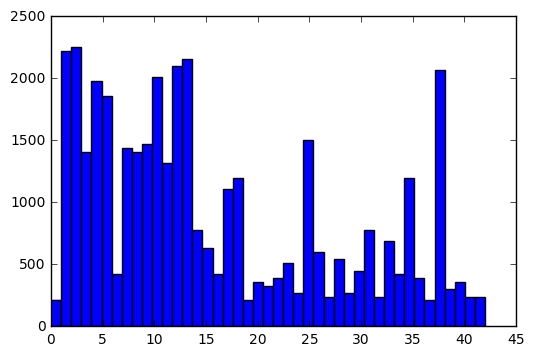

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Read and display different sign name from signnames.cvs and its counts
name = pd.read_csv('signnames.csv')
# Get a count of each traffic sign class.
train_label_counts = pd.Series(y_train, name='SampleCount').value_counts()
# Merge traffic sign class counts with class names and sort my class counts.
train_label_counts_names = name.join(train_label_counts)
#plt.figure(); train_label_counts_names['SampleCount'].plot(kind='bar')
#plt.figure(); plt.bar(train_label_counts_names.ClassId,train_label_counts_names.LabelCount)
plt.figure(); plt.hist(y_train,bins=n_classes)
train_label_counts_names

Display random sample from each classes


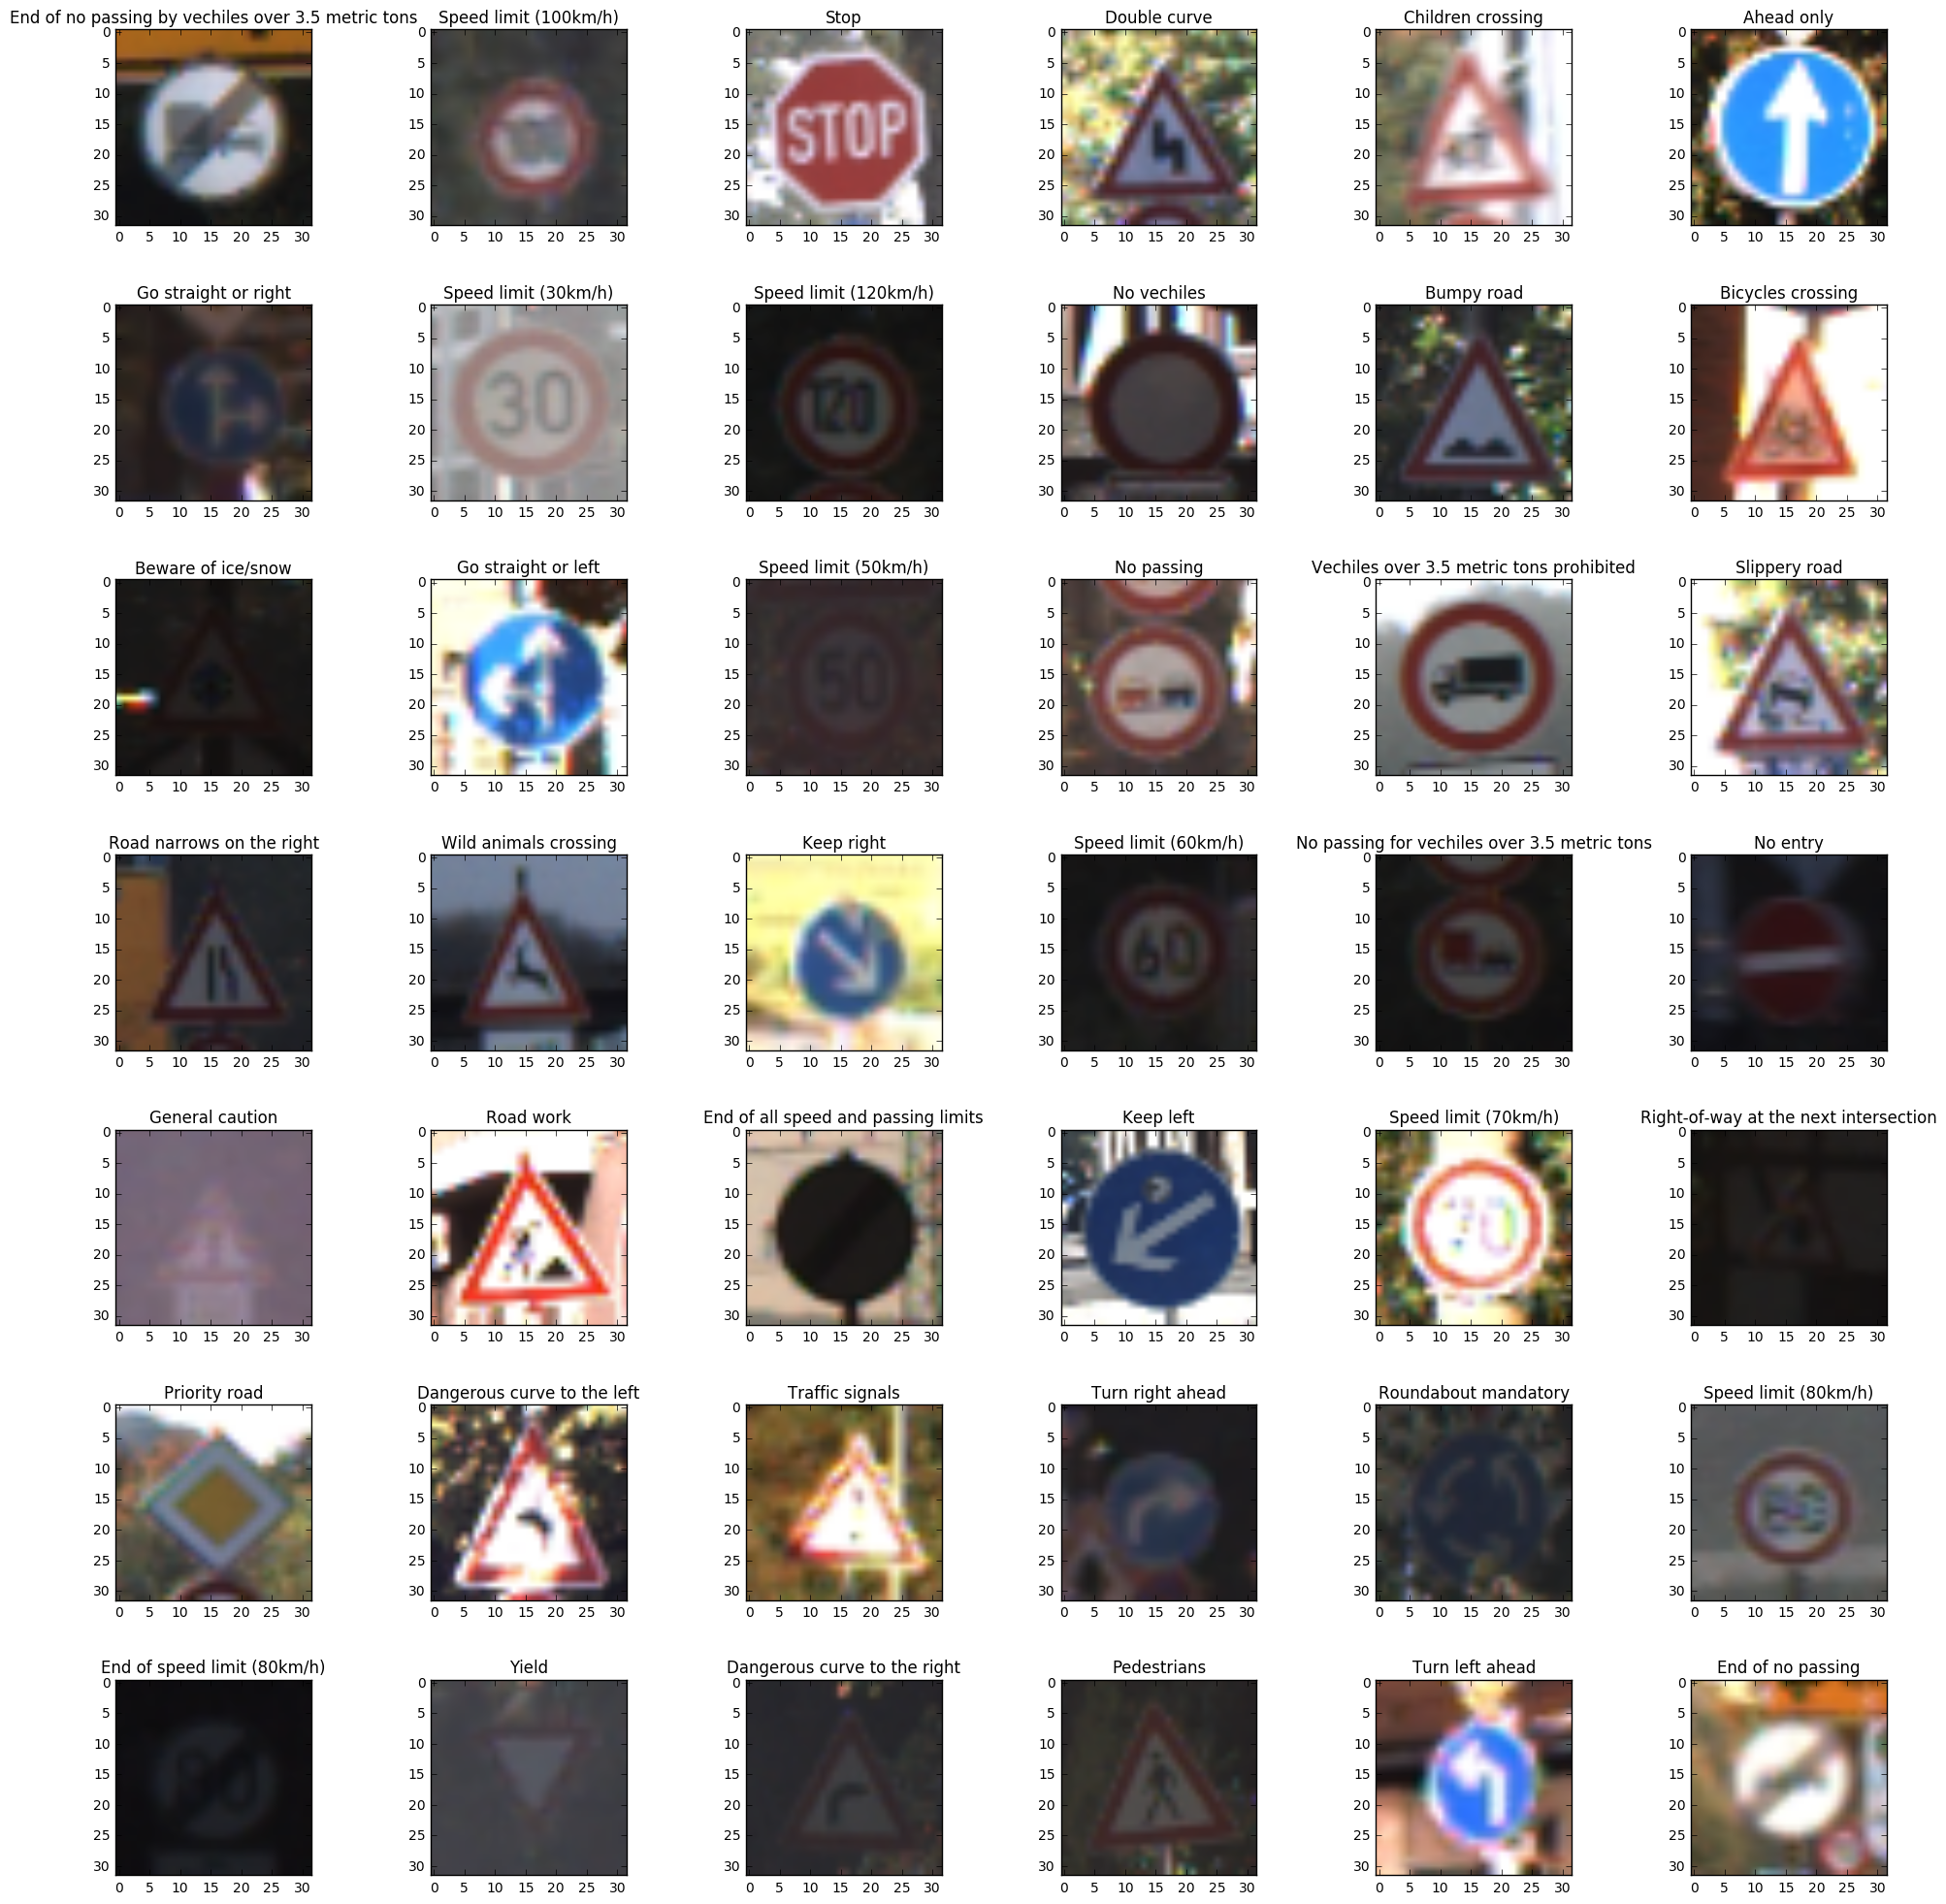

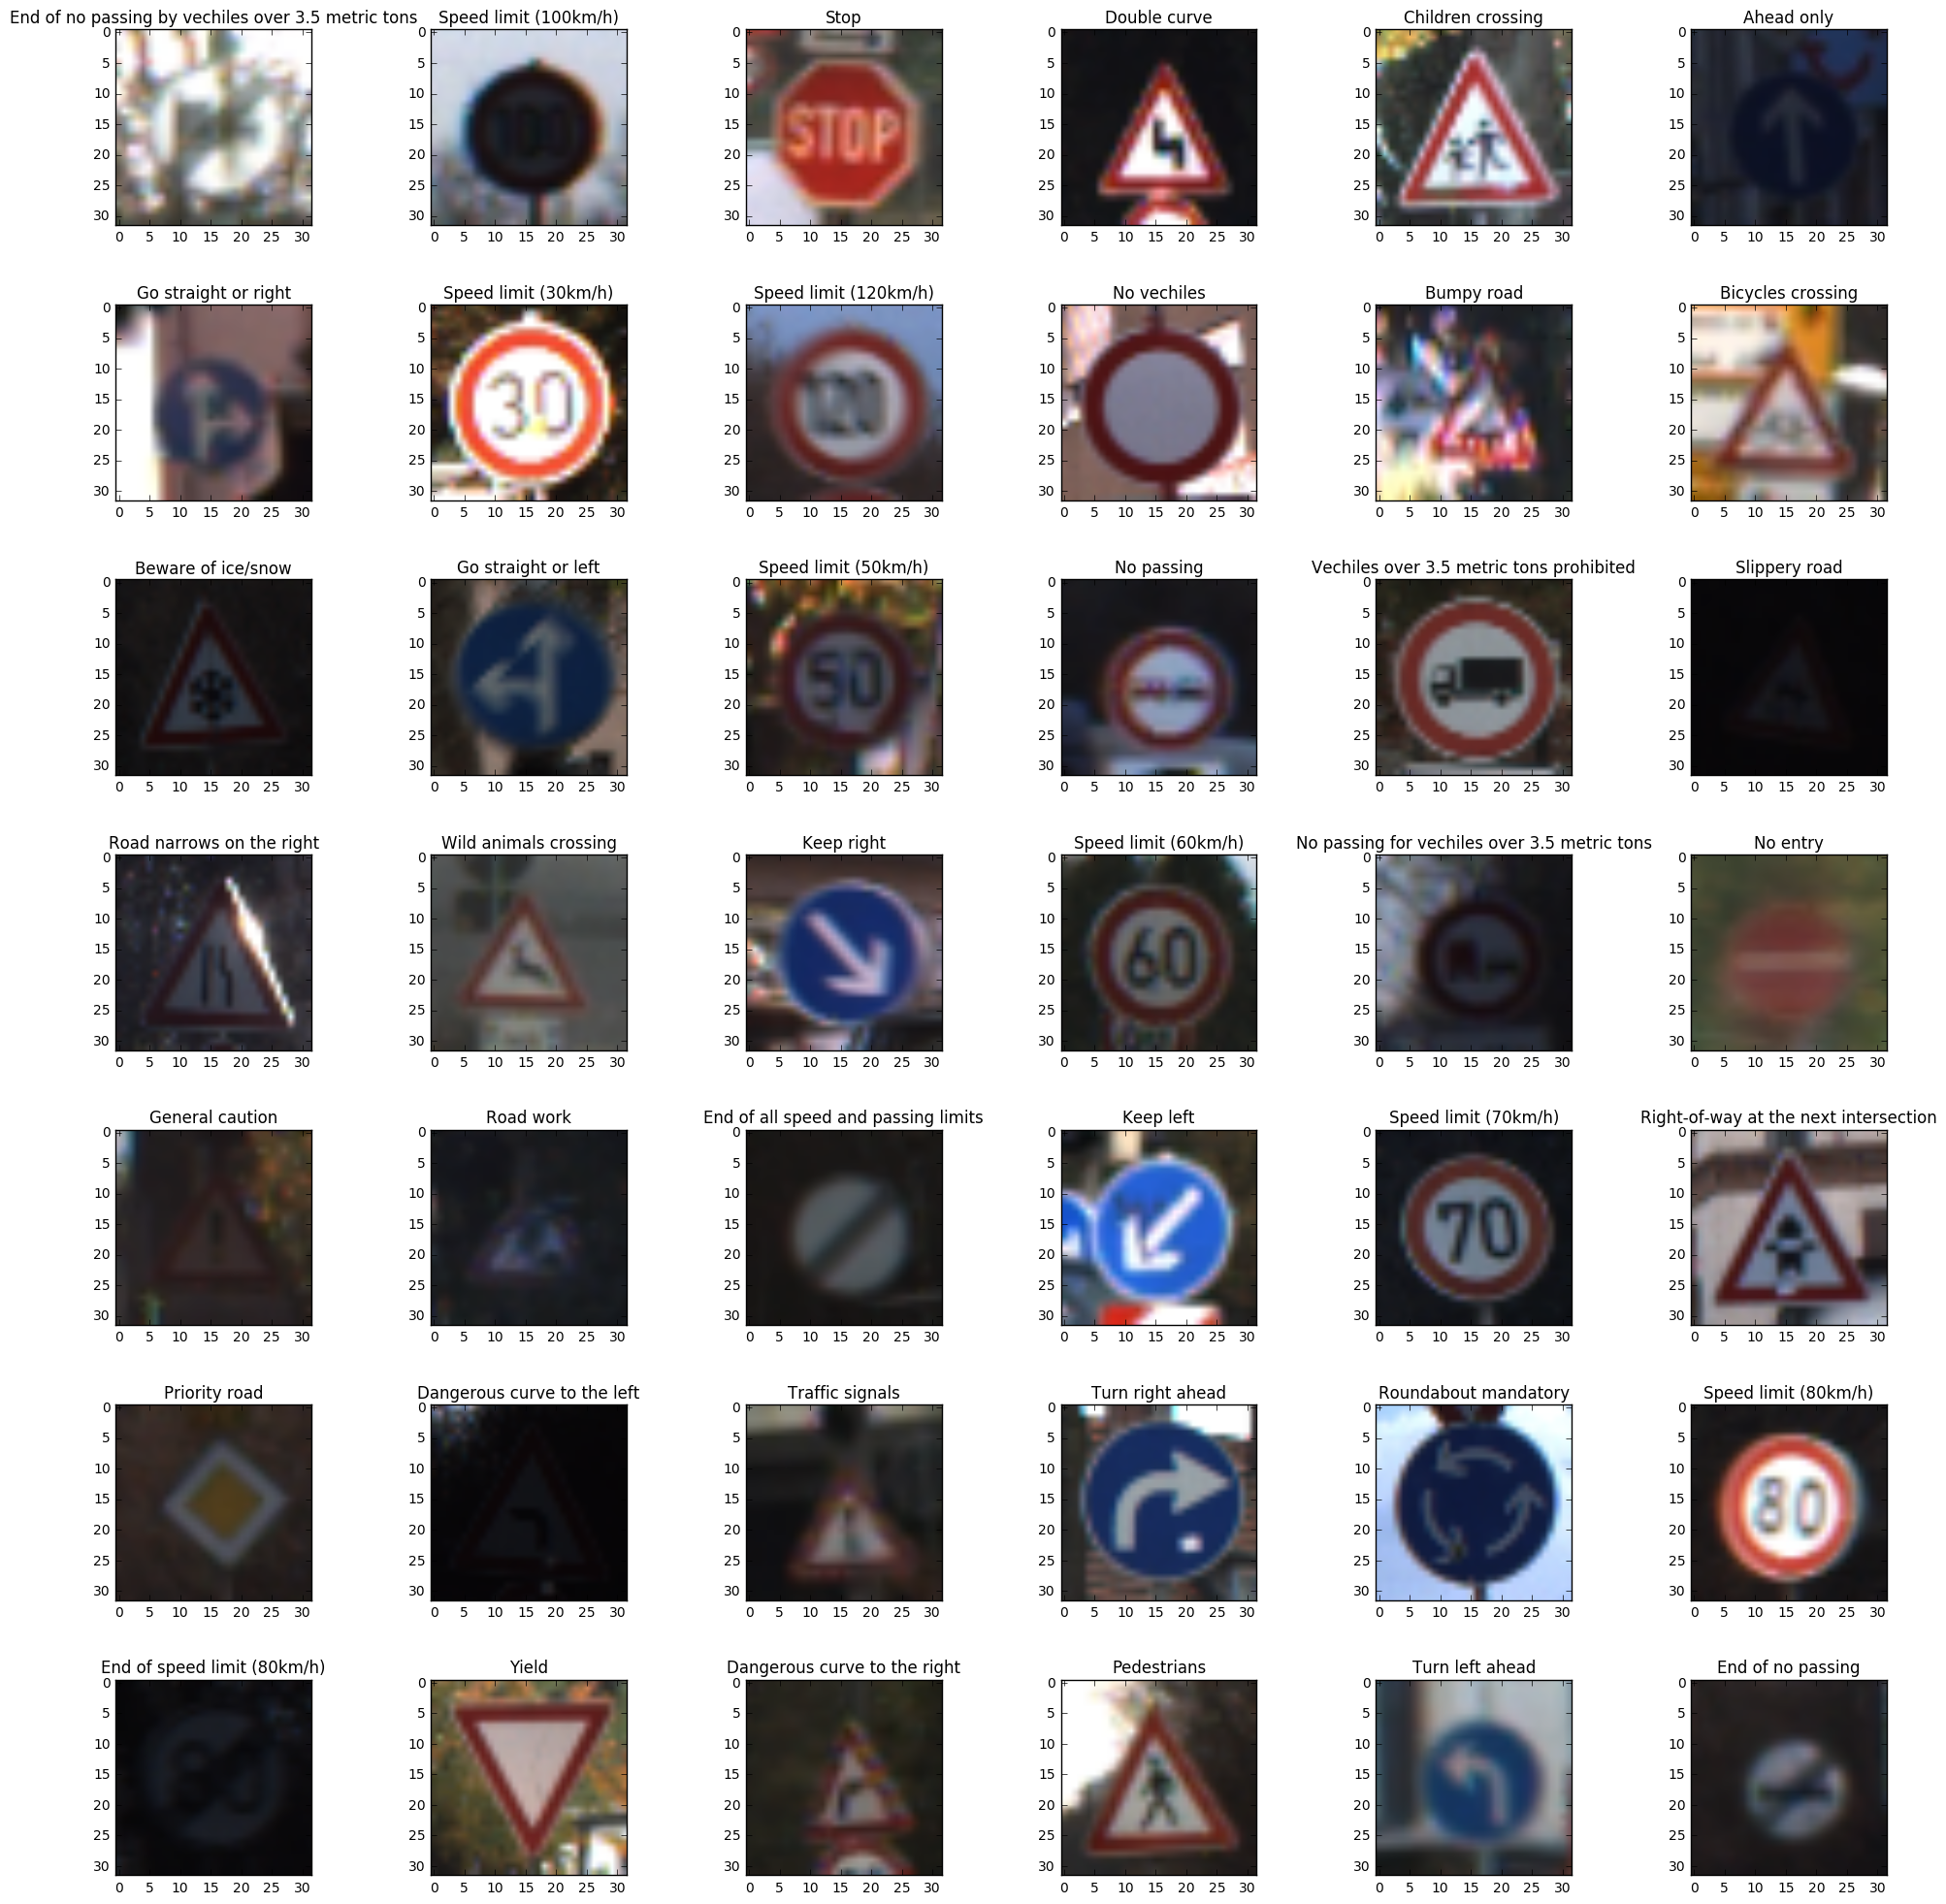

In [4]:
# This function is used to display sample images from train and test datasets
def display_sample_images(images,labels):
    SignNames = pd.read_csv('signnames.csv')
    _, ax = plt.subplots(7,6,figsize=(20,20))
    for ClassId, SignName in zip(SignNames.ClassId, SignNames.SignName):
        # Random select an image from particular class
        idx = np.argwhere(labels == ClassId)[np.random.randint(0, 20)][0]
        ax[ClassId % 7, ClassId % 6].imshow(images[idx])
        ax[ClassId % 7, ClassId % 6].set_title(SignName)
    plt.tight_layout()

print('Display random sample from each classes')

display_sample_images(X_train, y_train)
display_sample_images(X_test, y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# This controls the output range in normalization
image_value_ranges = [0.1,0.9]

def convert_rgb2yuv(image_data):
    """
    Converts input RGB data to YUV format
    """
    yuv_image_data = []
    if len(image_data.shape) > 3: 
        for i in range(len(image_data)):
            yuv_image_data.append(cv2.cvtColor(image_data[i], cv2.COLOR_RGB2YUV))
    else:
    # this else part is used when an single image is inputted for pre-processing rather than batch of images
        yuv_image_data.append(cv2.cvtColor(image_data, cv2.COLOR_RGB2YUV))
    return np.array(yuv_image_data)

def convert_rgb2gray(image_data):
    gray_image_data = []
    for i in range(len(image_data)):
        gray_image_data.append(cv2.cvtColor(image_data[i], cv2.COLOR_RGB2GRAY))
    return np.array(gray_image_data)


def normalize_Y_lecun(image_data):
    """
    This function tries to replicate pre-processing in Lecun paper. Input to this function is Y channel
    return mean and std normalized image in image_value_ranges
    """
    im_data = np.array(image_data,np.float32)
    #im_reshape = np.reshape(image_data,(-1,1024))
    #standard_scaler = StandardScaler(with_mean=True)
    #im_rescale = standard_scaler.fit_transform(im_reshape)
    #im_rescale = scale(im_reshape, axis=0, with_mean=True, with_std=False)
    #im_data = np.reshape(im_rescale,(-1,32,32))
    minV = np.amin(im_data)
    maxV = np.amax(im_data)
    lowerLimit = image_value_ranges[0]
    upperLimit = image_value_ranges[1]
    im_data =  lowerLimit + ((im_data - minV)*(upperLimit - lowerLimit))/(maxV - minV)
    return im_data

def normalize_Y(image_data,sub_mean = False,use_channel=False):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    minV = np.amin(image_data)
    maxV = np.amax(image_data)
    lowerLimit = image_value_ranges[0]
    upperLimit = image_value_ranges[1]
    image_data = np.array(image_data,np.float32)
    image_data[:,:,:,0] =  lowerLimit + ((image_data[:,:,:,0] - minV)*(upperLimit - lowerLimit))/(maxV - minV)
    #image_data =  lowerLimit + ((image_data - minV)*(upperLimit - lowerLimit))/(maxV - minV)
    if sub_mean:
        image_data[:,:,:,0] = image_data[:,:,:,0] - np.mean(image_data[:,:,:,0], axis=0)
    if use_channel:
        return image_data
    else:
        return image_data[:,:,:,0]

def preprocess_images(image_data, use_only_y = True, use_mean = False):
    """
    This is the main function to perform pre-processing. It supports single and color channel processing
    set use_only_y = true --> to process only single y channel
    set use_only_y = false --> to process yuv channels
    set use_mean = false --> To subtract image mean 
    """
    # Convert rgb color format to yuv format 
    p_image_data = convert_rgb2yuv(image_data)    
    if use_only_y:
        p_image_data = normalize_Y_lecun(p_image_data[:,:,:,0])
        #p_image_data = normalize_Y(p_image_data,use_channel=False)
    else:
        p_image_data = normalize_Y(p_image_data,use_channel=True)

    return p_image_data

def pre_process_images_test(image_data, mean_value, std_value):
    """
    This function uses training image mean and std to normalize test images.
    Currently this is not implemented
    """
    #p_image_data = convert_rgb2yuv(image_data)
    #p_image_data = normalize_Y_test(p_image_data[:,:,:,0])
    #return p_image_data
    
print('Image preprocessing is defined and successful..')
is_preprocess_defined = True

# testing the functionality
#idx = np.random.randint(n_train)
#sample_input_image = cv2.cvtColor(X_train[idx], cv2.COLOR_RGB2GRAY)
#sample_processed_image = preprocess_images(X_train[idx])
#_, ax = plt.subplots(2,2)
#ax[0,0].imshow(sample_input_image, cmap='gray')
#ax[0,0].set_title('RGB Gray Image')
#ax[0,1].imshow(sample_input_image, cmap='gray')
#ax[0,1].set_title('Normalized Y Image')

#ax[1,0].set_title('RGB Gray Image Histogram')
#_= ax[1,0].hist(sample_input_image.ravel(),bins=256, color='black')
#ax[1,1].set_title('Normalized Y Image Histogram')
#_= ax[1,1].hist(sample_processed_image.ravel(),bins=256, color='black')
#plt.tight_layout()

Image preprocessing is defined and successful..


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Preprocessing techniques used are as follows:

**1) Normalize RGB images directly in range of [0.1, 0.9] or [-0.5, 0.5] or [-1, 1] **<br />
**2) Convert RGB to YUV and Normalize YUV components in range of [0.1, 0.9] or [-0.5, 0.5] or [-1, 1] ** <br />
**3) Convret RGB to YUV and Normalize Y components images in range of [0.1, 0.9] or [-0.5, 0.5] or [-1, 1] ** <br />
**4) Convert RGB to YUV and perform mean and std normalization as described in Lecun paper and then convert images in range of [0.1, 0.9] or [-0.5, 0.5] or [-1, 1] ** <br />
**5) Convert RGB to Gray and Normalize gray component in range of [0.1, 0.9] or [-0.5, 0.5] or [-1, 1]** <br />

Based on the experiments conducted, the method 3) seems to perform better than other methods described. Some how network is not able to utilize color components in better way. Deeper insights and experiments are requried to analyse the cause fo color image poor performance
Method 4) described in the paper is not used as there is need to maintain mean and std values used in training and use it while normalizing the test images. Due to time constraint, I have not implemented this approach <br />

**Why preprocessing:** <br />
Preprocessing is like conditioning data to make it easier to find optimum solution. While performing gradient descent, if the data is normalized, then global minima can be reached in much better way <br /><br />
Since using RGB does not have any pure intensity information, it tends to perform poorer. Converting data to YUV overcomes this drawback. As Y component plays the role of the intensity. 

In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Definitions to jitter input data to provide additional data
assert is_preprocess_defined,'Preprocessing image functions not defined'

def shift_image_location(image, xoffset, yoffset):
    """
    Shift images across x and y axis
    Range of the shift is restricted between [-2,2] across each axis
    """
    rows,cols, depth = image.shape
    tparam = skimage_tf.AffineTransform(translation = (xoffset,yoffset))
    out = skimage_tf.warp(image,tparam)
    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    # This conversion is required as OpenCV rgb2yuv does not accept float64
    return out.astype(np.float32)
    
# function to rotate images by given degrees
def rotate_image(image, degree):
    """
    Rotates images using given degree
    Rotation is restricted between [-10, 10] degree
    """
    rows, cols, depth = image.shape
    rad = (np.pi / 180) * degree
    tparam = skimage_tf.AffineTransform(rotation = rad)
    out = skimage_tf.warp(image,tparam)
    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    return out.astype(np.float32)
    
# function to resize the image
def scale_image(image, ratio):
    """
    Scales the input image and maintain the input shape
    Scale is restricted between [0.9, 1.1] degree
    """
    rows, cols, depth = image.shape
    scale = skimage_tf.rescale(image,ratio)
    m_rows, m_cols, m_depth = scale.shape
    #print(ratio)
    #print(scale.shape)
    if ratio > 1.0:
        #print('GT')
        offset = m_rows - rows
        out = scale[offset:offset+rows, offset:offset+cols]
    else:
        #print('LT')
        out = np.zeros((rows,cols,depth))
        offset = rows - m_rows
        out[offset:offset+rows, offset:offset+cols] = scale
    
    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    return out.astype(np.float32)

def affine_image(image, xoffset, yoffset, degree, ratio):
    """
    Performs affine transform i.e. shift, rotate and scale
    """
    out = shift_image_location(image, xoffset, yoffset)
    out = rotate_image(out, degree)
    out = scale_image(out,ratio)
    return out.astype(np.float32)

def change_intensity(image, choice):
    """
    Modify image intensity using either gamma, log and sigmoid based on input random choice 
    """
    rows, cols, depth = image.shape
    if choice == 1:
        rnd = 2 * np.random.random()
        out = exposure.adjust_gamma(image,gamma=rnd)
    elif choice == 2:
        out = exposure.adjust_log(image)
    else:
        out = exposure.adjust_sigmoid(image)

    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    return out.astype(np.float32)

def combined_operations(image, xoffset, yoffset, degree, ratio, choice):
    """
    Function to combine all the jitter operations in one place
    """
    out = shift_image_location(image, xoffset, yoffset)
    out = rotate_image(out, degree)
    out = scale_image(out,ratio)
    out = change_intensity(out, choice)
    return out.astype(np.float32)

def jitter_image_data(input_images,input_labels,batch_size):
    """
    Jitter the input data. Performs scale, shift, rotate and intensity change
    Given batches of images performs jitter and return jittered data
    Input and output shapes remain the same
    """
    num_images = input_images.shape[0]
    jitter_images = []
    jitter_images_labels = [] 
    indx = np.random.choice(input_images.shape[0],batch_size,replace = False)
    images = input_images[indx]
    labels = input_labels[indx]
    for imageIdx in range(batch_size):
        # shift x range [-2,2]
        xoffset = int(4 * np.random.random() - 2)
        # shift y range [-2,2]
        yoffset = int(4 * np.random.random() - 2)
        # rotate range [-10,10]
        degree = int (20 * np.random.random() - 10)
        # scale range [0.9, 1.1]
        ratio = 0.2 * np.random.random() + 0.9
        # random intensity choices (gamma, log, sigmoid)
        choice = np.random.randint(4)
        # Jitter input image and appends the result
        jitter_images.append(combined_operations(images[imageIdx], xoffset, yoffset, degree, ratio, choice))
        # Append corresponding label
        jitter_images_labels.append(labels[imageIdx])
    
    return preprocess_images(np.array(jitter_images)), np.array(jitter_images_labels)


def jitter_image_data_old(input_images,input_labels,batch_size):
    """
    Jitter the input data. Performs scale, shift, rotate and intensity change.
    For every images in batch, corresponding five jitter images are created
    Random selection of batch_size from 5*batch_size jitter images
    """
    num_images = input_images.shape[0]
    jitter_images = []
    jitter_images_labels = [] 
    indx = np.random.choice(input_images.shape[0],batch_size,replace = False)
    images = input_images[indx]
    labels = input_labels[indx]
    for imageIdx in range(batch_size):
            xoffset = int(4 * np.random.random() - 2)
            yoffset = int(4 * np.random.random() - 2)
            degree = int (20 * np.random.random() - 10)
            ratio = 0.2 * np.random.random() + 0.9
            choice = np.random.randint(4)
            # Add original image to the jitter data
            jitter_images.append(images[imageIdx])
            jitter_images_labels.append(labels[imageIdx])
            # Shift image
            jitter_images.append(shift_image_location(images[imageIdx], xoffset, yoffset))
            jitter_images_labels.append(labels[imageIdx])
            # Rotate image
            jitter_images.append(rotate_image(images[imageIdx], degree))
            jitter_images_labels.append(labels[imageIdx])
            # Scale image
            jitter_images.append(scale_image(images[imageIdx], ratio))
            jitter_images_labels.append(labels[imageIdx])
            # Affine
            jitter_images.append(affine_image(images[imageIdx], xoffset, yoffset, degree, ratio))
            jitter_images_labels.append(labels[imageIdx])
            # Brightness
            jitter_images.append(change_intensity(images[imageIdx], choice))
            jitter_images_labels.append(labels[imageIdx])
    
    s_ind = np.random.choice(input_images.shape[0],batch_size)
    
    assert(len(s_ind) == batch_size)
    
    return preprocess_images(np.array(jitter_images)[s_ind]), np.array(jitter_images_labels)[s_ind]

# Testing
#samples = X_train[1:100] 
#slabels = y_train[1:100]
#out1, out2 = jitter_image_data(samples,slabels,32)

In [7]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

print('Labels One-Hot Encoded')
is_labels_encod = True
is_train_test_split = False

Labels One-Hot Encoded


In [8]:
# Perform data split for training, validation and testing
assert is_preprocess_defined, 'You skipped the step to preprocess the images'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

if not is_train_test_split:
    # Get randomized datasets for training and validation
    train_features, valid_features, train_labels, valid_labels = train_test_split(
        X_train,
        train_labels,
        test_size=0.05,
        random_state=832289)

    #test_features = preprocess_images(X_test)

    print('Training features and labels randomized and split.')
    print('Number of training images {}'.format(train_features.shape[0]))
    print('Number of validation images {}'.format(valid_features.shape[0]))
    print('Number of testing images {}'.format(X_test.shape[0]))

is_train_test_split = True

Training features and labels randomized and split.
Number of training images 37248
Number of validation images 1961
Number of testing images 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In machine or deep learning, in order to train a superivised model we will first collect data. Once data is available, then training is performed on the data. In order to get the essence of how the model is performing test data is needed. This test data cannot be a subset of training data. Because, then testing would not generalize well. So in order to evaluate a model, we need to split the data as training and test data. 

Now comes another problem. Since there are always more hyperparameters to choose from, how to get the essence of how well your trained model performed without looking into test set. If the test set is used again for this purpose, then parameter tuning will inherit some property in relation to test set and again we will lose generalization. So, in order to avoid it, training set is again splitted into training and validation set. After the model is trained, it is tested in validation set and fined tune to obtain maximump performance in both training and validation. Since validation was actually a part of training set, even if model inherits properties from validation set, we dont bother. After all the fine tuning is done, then model is tested against test set to get the actually performance.

In this lab, training and test data is already given. So there is need to split only training data into training and validation set. This is acheived using train_test_split function from sklearn. Since data is small and in order to utilize all the available data for training, only 5% of the training data is used as validation. Nevertheless, it is sufficient to fine tune hyperparameters. 

One of the major advancement that favored people towards deep learning is the availability of data. Even though this problem looks trivial, additional data is important. It is not always possible to capture data under different conditions like dawn, dusk, night, etc. It is also expensive to collect data. Even though a model is trained with available data and also we expect the model to perform good at all condition. For all these reasons additional data is used.

In [9]:
#Placeholder definition
features = tf.placeholder(tf.float32, [None, 32, 32])
image = tf.reshape(features, [-1,32,32,1])
keep_prob = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32, [None, 43])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def model_twolayers():
    endpoints = {}
    with tf.variable_scope('conv1') as scope:
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)
        endpoints['conv1'] = h_conv1
        endpoints['conv1_pool1'] = h_pool1
    
    with tf.variable_scope('conv2') as scope:
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)
        endpoints['conv2'] = h_conv2
        endpoints['conv2_pool2'] = h_pool2

    with tf.variable_scope('fc1') as scope:
        W_fc1 = weight_variable([8*8*64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        endpoints['fc1'] = h_fc1_drop
    
    with tf.variable_scope('fc2') as scope:
        W_fc2 = weight_variable([1024, 43])
        b_fc2 = bias_variable([43])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        endpoints['logits'] = logits
    
    return logits, endpoints

def model_fourlayers():
    endpoints = {}
    with tf.variable_scope('conv1') as scope:
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)
        endpoints['conv1'] = h_conv1
        endpoints['conv1_pool1'] = h_pool1
    
    with tf.variable_scope('conv2') as scope:
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)
        endpoints['conv2'] = h_conv2
        endpoints['conv2_pool2'] = h_pool2
    
    with tf.variable_scope('conv3') as scope:
        W_conv3 = weight_variable([5, 5, 64, 128])
        b_conv3 = bias_variable([128])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
        h_pool3 = max_pool_2x2(h_conv3)
        endpoints['conv3'] = h_conv3
        endpoints['conv3_pool3'] = h_pool3
    
    with tf.variable_scope('conv4') as scope:
        W_conv4 = weight_variable([3, 3, 128, 256])
        b_conv4 = bias_variable([256])
        h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
        h_pool4 = max_pool_2x2(h_conv4)
        endpoints['conv4'] = h_conv4
        endpoints['conv4_pool4'] = h_pool4

    with tf.variable_scope('fc1') as scope:
        W_fc1 = weight_variable([2*2*256, 512])
        b_fc1 = bias_variable([512])
        h_pool4_flat = tf.reshape(h_pool4, [-1, 2*2*256])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        endpoints['fc1'] = h_fc1_drop
    
    with tf.variable_scope('fc2') as scope:
        W_fc2 = weight_variable([512, 43])
        b_fc2 = bias_variable([43])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        endpoints['logits'] = logits
    
    return logits, endpoints

def loss(logits, labels):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
    return loss

def training(loss, learning_rate, name = 'Adam'):
    if name == 'GD':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    else:
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer

def evaluation(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [10]:
print('Model Architecture for two layers is as follows')
_, conv_dict1 = model_twolayers()
conv_dict1

Model Architecture for two layers is as follows


{'conv1': <tf.Tensor 'conv1/Relu:0' shape=(?, 32, 32, 32) dtype=float32>,
 'conv1_pool1': <tf.Tensor 'conv1/MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>,
 'conv2': <tf.Tensor 'conv2/Relu:0' shape=(?, 16, 16, 64) dtype=float32>,
 'conv2_pool2': <tf.Tensor 'conv2/MaxPool:0' shape=(?, 8, 8, 64) dtype=float32>,
 'fc1': <tf.Tensor 'fc1/dropout/mul:0' shape=(?, 1024) dtype=float32>,
 'logits': <tf.Tensor 'fc2/add:0' shape=(?, 43) dtype=float32>}

In [11]:
print('Model Architecture for four layers is as follows')
_, conv_dict2 = model_fourlayers()
conv_dict2

Model Architecture for four layers is as follows


{'conv1': <tf.Tensor 'conv1_1/Relu:0' shape=(?, 32, 32, 32) dtype=float32>,
 'conv1_pool1': <tf.Tensor 'conv1_1/MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>,
 'conv2': <tf.Tensor 'conv2_1/Relu:0' shape=(?, 16, 16, 64) dtype=float32>,
 'conv2_pool2': <tf.Tensor 'conv2_1/MaxPool:0' shape=(?, 8, 8, 64) dtype=float32>,
 'conv3': <tf.Tensor 'conv3/Relu:0' shape=(?, 8, 8, 128) dtype=float32>,
 'conv3_pool3': <tf.Tensor 'conv3/MaxPool:0' shape=(?, 4, 4, 128) dtype=float32>,
 'conv4': <tf.Tensor 'conv4/Relu:0' shape=(?, 4, 4, 256) dtype=float32>,
 'conv4_pool4': <tf.Tensor 'conv4/MaxPool:0' shape=(?, 2, 2, 256) dtype=float32>,
 'fc1': <tf.Tensor 'fc1_1/dropout/mul:0' shape=(?, 512) dtype=float32>,
 'logits': <tf.Tensor 'fc2_1/add:0' shape=(?, 43) dtype=float32>}

### Note:
**The following cell contains the same model as the above. But it has organised so that model can be saved and load as when required. Using the above method made it difficult to store and restore models due to different architectures tried and tested**

In [ ]:
# The following cell contains the same model as the above. But it has organised so that model can be saved and load as when required. 
# Using the above method made it difficult to store and restore models due to different architectures tried and tested

# Graph name to enable restore
graph_model_simple = tf.Graph()

with graph_model_simple.as_default():
    
    features = tf.placeholder(tf.float32, [None, 32, 32])
    image = tf.reshape(features, [-1,32,32,1])
    keep_prob = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    def model_twolayers():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([8*8*64, 1024])
            b_fc1 = bias_variable([1024])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop

        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([1024, 43])
            b_fc2 = bias_variable([43])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            endpoints['logits'] = logits

        return logits, endpoints

    def model_fourlayers():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2

        with tf.variable_scope('conv3') as scope:
            W_conv3 = weight_variable([5, 5, 64, 128])
            b_conv3 = bias_variable([128])
            h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
            h_pool3 = max_pool_2x2(h_conv3)
            endpoints['conv3'] = h_conv3
            endpoints['conv3_pool3'] = h_pool3

        with tf.variable_scope('conv4') as scope:
            W_conv4 = weight_variable([3, 3, 128, 256])
            b_conv4 = bias_variable([256])
            h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
            h_pool4 = max_pool_2x2(h_conv4)
            endpoints['conv4'] = h_conv4
            endpoints['conv4_pool4'] = h_pool4

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([2*2*256, 512])
            b_fc1 = bias_variable([512])
            h_pool4_flat = tf.reshape(h_pool4, [-1, 2*2*256])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop

        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([512, 43])
            b_fc2 = bias_variable([43])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            endpoints['logits'] = logits

        return logits, endpoints

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def prediction_prob(logits):
        return tf.nn.softmax(logits)
    
    def prediction_class(logits):
        return tf.nn.top_k(logits)
    
    # This remains fixed for this graph. If you need to use model_fourlayers has to enable here
    logits, _ = model_twolayers()
    losses = loss(logits,labels)
    train_op = training(losses, 0.001)
    acc = evaluation(logits,labels)
    pred = prediction_prob(logits)
    pred_class = prediction_class(logits)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

In [12]:
#Placeholder definition
import tensorflow as tf
graph_model_multi2 = tf.Graph()

with graph_model_multi2.as_default():
    
    features = tf.placeholder(tf.float32, [None, 32, 32])
    image = tf.reshape(features, [-1,32,32,1])
    keep_prob = tf.placeholder(tf.float32)
    lr_value = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    def model():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2
        
        with tf.variable_scope('combined') as scope:
            h_pool1_flat = tf.reshape(h_pool1, [-1, 16*16*32])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
            combined_pool_flat = tf.concat(1, [h_pool1_flat, h_pool2_flat])
            combined_pool_flat_shape = combined_pool_flat.get_shape()[1].value
            endpoints['combined'] = combined_pool_flat

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([combined_pool_flat_shape, 1024])
            b_fc1 = bias_variable([1024])
            h_fc1 = tf.nn.relu(tf.matmul(combined_pool_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop
        
        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([1024, 100])
            b_fc2 = bias_variable([100])
            h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
            h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)
            endpoints['fc2'] = h_fc2_drop
            
        with tf.variable_scope('fc3') as scope:
            W_fc3 = weight_variable([100, 43])
            b_fc3 = bias_variable([43])
            logits = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
            endpoints['logits'] = logits

        return logits, endpoints

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def prediction_prob(logits):
        return tf.nn.softmax(logits)
    
    def prediction_class(logits):
        return tf.nn.top_k(logits)
    
    logits, graphdef = model()
    losses = loss(logits,labels)
    train_op = training(losses, lr_value)
    acc = evaluation(logits,labels)
    pred = prediction_prob(logits)
    pred_class = prediction_class(logits)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

print('MultiScale model2 defined..')
graphdef

MultiScale model2 defined..


{'combined': <tf.Tensor 'combined/concat:0' shape=(?, 12288) dtype=float32>,
 'conv1': <tf.Tensor 'conv1/Relu:0' shape=(?, 32, 32, 32) dtype=float32>,
 'conv1_pool1': <tf.Tensor 'conv1/MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>,
 'conv2': <tf.Tensor 'conv2/Relu:0' shape=(?, 16, 16, 64) dtype=float32>,
 'conv2_pool2': <tf.Tensor 'conv2/MaxPool:0' shape=(?, 8, 8, 64) dtype=float32>,
 'fc1': <tf.Tensor 'fc1/dropout/mul:0' shape=(?, 1024) dtype=float32>,
 'fc2': <tf.Tensor 'fc2/dropout/mul:0' shape=(?, 100) dtype=float32>,
 'logits': <tf.Tensor 'fc3/add:0' shape=(?, 43) dtype=float32>}

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I have experimented with numerous model. Please see Traffic_Signs_Recognition_ver2.ipynb for more experiments.
Basically my model can classified into two types as mentioned in Lecun's paper. Simple model with convolutional layers and multiscale model with convolutional layers

**Simple Model:** (Scrool above to see the model output with shape information)

*Two Layers: conv1->relu1->pool1->conv2->relu2->pool2->fc1->fc1_drop->fc2*
*Four Layers:conv1->relu1->pool1->conv2->relu2->pool2->conv3->relu3->pool3->conv4->relu4->pool4->fc1->fc1_drop->fc2*

**MultiScale Model:** (Scrool above to see the model output with shape information)

*Two Layers: conv1->relu1->pool1->conv2->relu2->pool2->fc1->fc1_drop->fc2*
                             |                           ^
                             V ------------------------->|
                    (output of pool1 is combined with pool2 in fc1) 

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [ ]:
def run_training(steps,batch_size,learning_rate,k_prob,use_jitter=False, modelname ='Two'):
    stime = time.time()
    sess = tf.InteractiveSession()

    if modelname == 'Four':
        logits, _ = model_fourlayers()
    else:
        logits, _ = model_twolayers()
    
    losses = loss(logits,labels)
    train_op = training(losses, learning_rate)
    acc = evaluation(logits,labels)
    tf.initialize_all_variables().run()
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    log_batch_step = 1000
    batches_history = []
       
    if not use_jitter:
        norm_train_features = preprocess_images(train_features)
    else:
        norm_train_features = train_features
    
    norm_valid_features = preprocess_images(valid_features)
    norn_test_features = preprocess_images(X_test[1:1000])
    
    valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}
    test_feed_dict = {features: norn_test_features, labels : test_labels[1:1000], keep_prob: 1}
    
    print('Training model with {} layers started for step: {} batchsize: {} learning_rate: {} keep_prob: {}'.format(modelname, steps,batch_size,learning_rate,k_prob))
    
    for step in range(steps):
        # Get a batch of training features and labels
        #batch_start = batch_i*batch_size
        #batch_features = train_features[batch_start:batch_start + batch_size]
        #batch_labels = train_labels[batch_start:batch_start + batch_size]
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)

        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})
                
        if step%log_batch_step == 0:
            train_accuracy = acc.eval(feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
            valid_accuracy = acc.eval(feed_dict=valid_feed_dict)
            test_accuracy = acc.eval(feed_dict=test_feed_dict)
            print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            previous_batch = batches_history[-1] if batches_history else 0
            batches_history.append(log_batch_step + previous_batch)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(valid_accuracy)
            loss_history.append(loss_value)
        
    # Check accuracy against Test data
    test_accuracy = sess.run(acc, feed_dict=test_feed_dict)
    
    print('Training completed with test accuracy : {}'.format(test_accuracy))
    
    return batches_history, train_acc_history, val_acc_history, test_accuracy

In [ ]:
# fine tuning hyperparameters
# Flag to train with and without additional data
jit = [False, True]
# Select one of the two models
models = ['Two','Four']
# Steps size is fixed for experimentation so that performance can be observed at common point
steps = [10000]
# Experimenting with different batch sizes
batches = [32, 64, 128, 256]
# Experimenting with different learning rate
lr = [1e-2, 1e-3, 1e-4]
# Experimenting with different dropout probabilities
kp = [0.5, 0.65, 0.8]
result = []
best_acc = 0.0
best_params = []
for j in jit:
    for m in models:
        for s in steps:
            for b in batches:
                for l in lr:
                    for k in kp:
                        batch_val, train_acc, val_acc, test_acc = run_training(s,b,l,k,j,m)
                        if test_acc > best_acc:
                            best_acc = test_acc
                            best_params = [s,b,l,k,m]
                            batch_best = batch_val
                            acc_best = [train_acc, val_acc]

print('Best Validation Accuracy : {}'.format(best_acc))
print('Best parameters: steps:{} batches:{} learning_rate:{} keep_prob:{}'.format(best_params[0],best_params[1],best_params[2],best_params[3]))

acc_plot = plt.subplot()
acc_plot.set_title('Accuracy')
acc_plot.plot(batch_best, acc_best[0], 'g', label='Training Accuracy')
acc_plot.plot(batch_best, acc_best[1], 'r', label='Validation Accuracy')
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()


In [ ]:
# This is common code to train all the defined models
curr_path = os.getcwd()
model_path = curr_path +'/models/model_multi.ckpt'

# Define train or test model
train = True
# Use additional data for training
use_jitter = False
# Num of training iterations
steps = 100000
# Batch processing size
batch_size = 96
# Drop off probability
k_prob = 0.5
# Learning rate
learning_rate = 0.001
# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob, lr_value: learning_rate}

# Change this line to train the different models
# with tf.Session(graph=graph_model_simple) as sess:
# with tf.Session(graph=graph_model_multi) as sess:
with tf.Session(graph=graph_model_multi2) as sess:
    if train:
        sess.run(init)
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
                # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob, lr_value: learning_rate})

            if step%1000 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1, lr_value: learning_rate})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
                test_accuracy = total / batch_count
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))
                
                # This is just a hack to do decay learning rate
                if(test_accuracy > 0.96):
                    learning_rate = 0.0001

            if ((step == (steps-1)) or (test_accuracy > 0.98)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value:learning_rate})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,model_path)
                print("Model saved.")
    else:
        # Here's where you're restoring the variables w and b.
        # Note that the graph is exactly as it was when the variables were
        # saved in a prior training run.
        #ckpt = tf.train.get_checkpoint_state(check_dir)
        #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #print('Model Restored..')
        saver.restore(sess,model_path)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
        test_accuracy = total / batch_count
        print('Restored test accuracy: {}'.format(test_accuracy))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

With both simple and multiscale model defined, next step is the training. Usually training happen for steps or epoches. Here in order to keep randomized data, steps has been consider rather than epoch. Also, training happen for longer time and get the hyperparameters right is challenging. In order to avoid that, initial training with smaller step size is done varying hyperparameters. Even though this might not give best observation (especially for small learning rate), this method was used to get some inituation about hyperparameters. 

Based on above approach, hyperparameters were selected individual models with and without additioanal data.

Mostly these were the parameters used:

**Optimizer: Adam <br />
Batch Size: 64 or 128 <br />
epoch/steps : 1,00,0000 <br />
learning rate: 0.001 <br />
Dropout prob: 0.5 or 0.65**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

First I implemented a simple two layer convolutional model. Used a small testing with various hyperparameters and finalized best hyperparameters. Later trained models for longer iterations. With these initial step I was able to get around 94% accuracy on test set.

In order to further improve, I used additional data as mentioned in Lecun's paper. This produced result with 96%.

Later, I implemented multi-scale model to improve the accuracy further to 97%

In [ ]:
#If you encounter error, please run graph_model_simple definition cell before runnning this cell
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
batch_size = 128
best_test_accuracy = 0.0
best_model = []
for model_name in glob.glob('models/*.ckpt'):
    if 'simple' in model_name:
        sess = tf.Session(graph=graph_model_simple)
    
        sess.run(init)
        saver.restore(sess,model_name)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
        test_accuracy = total / batch_count
        print('Final Test Accuracy of {} is {}'.format(model_name,test_accuracy))
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model = model_name
        sess.close()
        
print('Best Test Accuracy is {} using {}'.format(best_test_accuracy, best_model))

In [13]:
#If you encounter error, please run graph_model_multi2 definition cell before runnning this cell.
# This seems to an issue, since varaibles are given same name, even with session separated out, you cannot run without model definition
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
batch_size = 128
best_test_accuracy = 0.0
best_model = []
for model_name in glob.glob('models/*.ckpt'):
    if 'multi' in model_name:
        sess = tf.Session(graph=graph_model_multi2)
    
        sess.run(init)
        saver.restore(sess,model_name)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
        test_accuracy = total / batch_count
        print('Final Test Accuracy of {} is {}'.format(model_name,test_accuracy))
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model = model_name
        sess.close()
        
print('Best Test Accuracy is {} using {}'.format(best_test_accuracy, best_model))

Final Test Accuracy of models/model_multi_jitter_small_iter.ckpt is 0.9493811660342746
Final Test Accuracy of models/model_multi.ckpt is 0.9727360816917034
Final Test Accuracy of models/model_multi_jitter.ckpt is 0.9743932786614004
Best Test Accuracy is 0.9743932786614004 using models/model_multi_jitter.ckpt


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

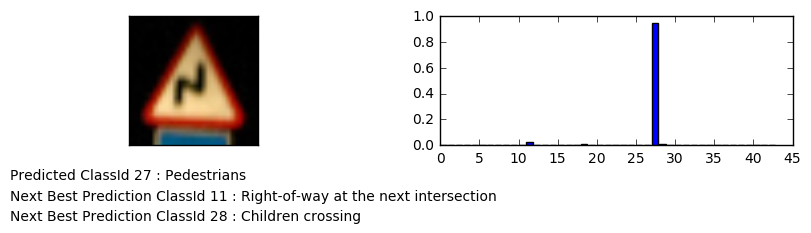

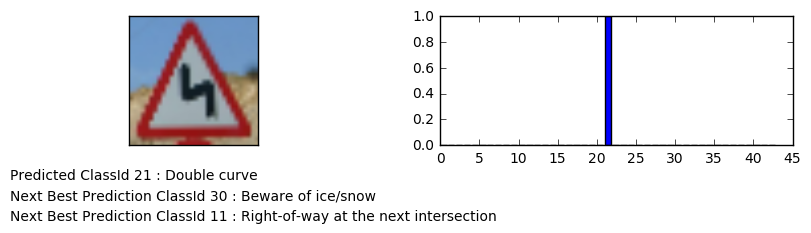

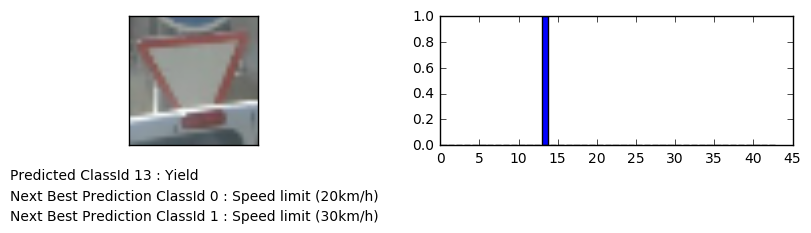

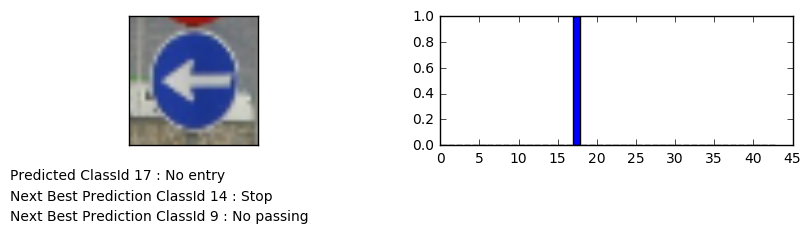

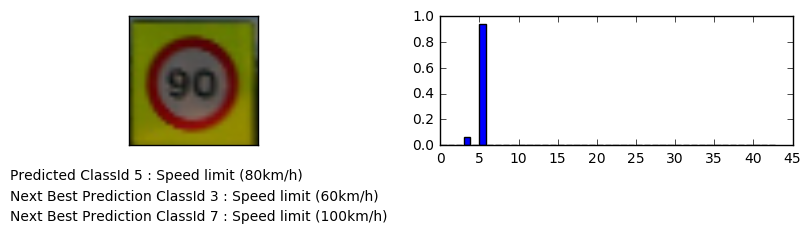

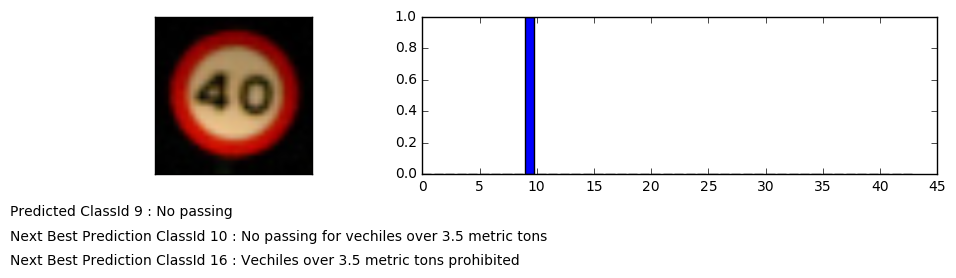

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
#http://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
import glob
import skimage.io as sk_io
from matplotlib import gridspec
name = pd.read_csv('signnames.csv')
curr_path = os.getcwd()
model_path = curr_path +'/models/model_multi_jitter.ckpt'
def read_new_images():
    processed_images = []
    for image_name in glob.glob('images/*.jpg'):
        image = sk_io.imread(image_name)
        resize_image = skimage_tf.resize(image,(32,32))
        processed_images.append(resize_image)

    return preprocess_images(np.float32(np.array(processed_images))), np.array(processed_images)
    
new_test_images, original_test_images = read_new_images()
with tf.Session(graph=graph_model_multi2) as sess:
    sess.run(init)
    saver.restore(sess,model_path)
    pred_value, pred_class_value = sess.run([pred,pred_class],feed_dict={features:new_test_images,keep_prob:1})
    #print(pred_class_value)
    top_3_classes = tf.nn.top_k(pred_value,k=3)
    top_3_classes_value = sess.run(top_3_classes)
    #print((top_3_classes_value))


num_new_test_images = pred_value.shape[0]
num_class_labels = pred_value.shape[1]
# Due to memory constraint, displaying only 5 images
num_display = 7
#rand_idx = np.random.choice(num_new_test_images,num_display)
rand_idx = [0,3,1,8,10,14]
sample_prob = pred_value[rand_idx]
sample_class = pred_class_value.indices[rand_idx]
sample_test_images = new_test_images[rand_idx]
sample_orig_images = original_test_images[rand_idx]
sample_top3_class = top_3_classes_value.indices[rand_idx]
index = np.arange(num_class_labels)
for idx in range(num_display-1):
    fig = plt.figure(figsize=(10, 10)) 
    gs = gridspec.GridSpec(1, 2, height_ratios=[1, 5])
    ax0 = plt.subplot(gs[0])
    #ax0.set_title('Predicted ClassId %d : %s'%(sample_class[idx][0], name.SignName[sample_class[idx][0]]))
    #ax0.set_xlabel('Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][1],name.SignName[sample_top3_class[idx][1]]))
    ax0.text(-30,40,'Predicted ClassId %d : %s'%(sample_class[idx][0], name.SignName[sample_class[idx][0]]))
    ax0.text(-30,45,'Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][1],name.SignName[sample_top3_class[idx][1]]))
    ax0.text(-30,50,'Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][2],name.SignName[sample_top3_class[idx][2]]))
    ax0.imshow(sample_orig_images[idx])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = plt.subplot(gs[1])
    ax1.bar(index, sample_prob[idx])
plt.tight_layout()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

Images used for testing has been obtained from Traffic Signs UAH Dataset (http://agamenon.tsc.uah.es/Investigacion/gram/traffic_signs.html). Since these images contains traffic sign as a part of an image, manual cropping has been done to extract the signs.

These images might contains following difficulties while performing classification

** 1) Change in Illumination **
** 2) Occlusion **
** 3) Shadow ** 
** 4) Deformation **

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

With limited testing done so far, overall the model was able to perform well on new images. This can be seen with seen image 2 and image 3 in the display above

**Image 2 --> Double curve --> Detected with high probability ** <br />
**Image 3 --> Yield        --> Detected with high probability even in occluded condition** <br />

The problem with model is that, for those images not available in the class label, it still predicts a higher probability. 

**Interesting observations:** <br />
Image 4 --> Although it resembles "keep left" (Keep left has slant white line in the middle) the model predicted as "no entry". This was due to horizontal line in both the cases. But background color of the sign is actually blue for "keep left" and red for "no entry". If color informations can be utilized properly, then we should get much better model.
<br /> <br />
**For images taken at night, the model did not predicted properly as seen in image 1 and 2 **

***Note on Performance***
Since there is a need to manually label the data to analyse the performance which is hectic, visualization has been used to study the performance.

In [15]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
batch_size = 128
best_test_accuracy = 0.0
best_model = []
is_correct_list = []
model_name = 'models/model_multi_jitter.ckpt'
sess = tf.Session(graph=graph_model_multi2)
sess.run(init)
saver.restore(sess,model_name)
feed_dict={features:norm_test_features, labels: test_labels, keep_prob: 1}
is_correct = sess.run(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), feed_dict=feed_dict)
misclassified_idxs = np.arange(len(norm_test_features))[~is_correct]
sess.close()

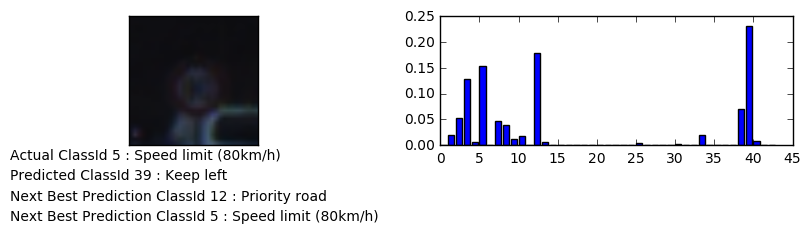

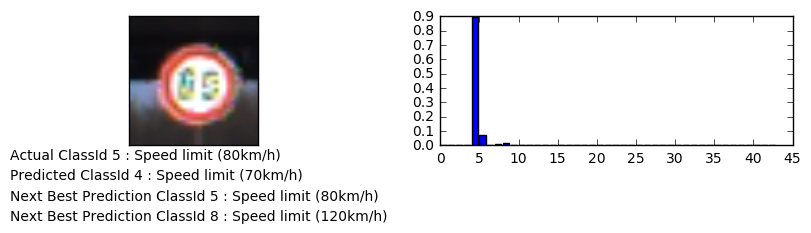

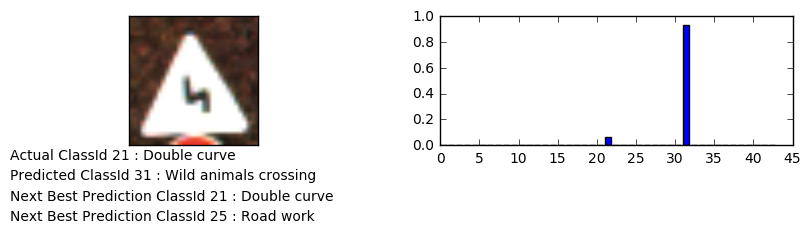

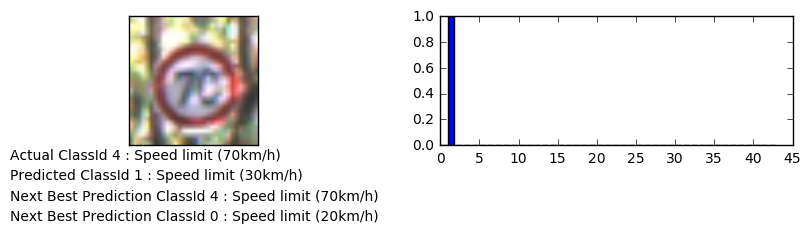

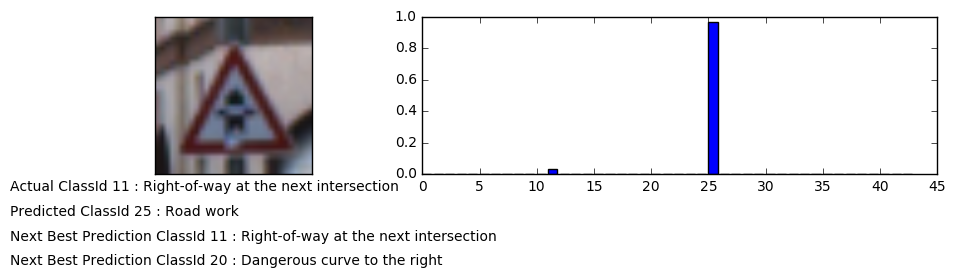

In [16]:
model_name = 'models/model_multi_jitter.ckpt'
misclassified_images_ = X_test[misclassified_idxs]
misclassified_labels = test_labels[misclassified_idxs]
misclassified_images = preprocess_images(misclassified_images_)
with tf.Session(graph=graph_model_multi2) as sess:
    sess.run(init)
    saver.restore(sess,model_name)
    pred_value, pred_class_value = sess.run([pred,pred_class],feed_dict={features:misclassified_images,keep_prob:1})
    top_3_classes = tf.nn.top_k(pred_value,k=3)
    top_3_classes_value = sess.run(top_3_classes)
num_display = 6
num_new_test_images = misclassified_images.shape[0]
rand_idx = np.random.choice(num_new_test_images,num_display)
rand_idx = [55, 61, 110, 113, 121]
sample_prob = pred_value[rand_idx]
sample_class = pred_class_value.indices[rand_idx]
actual_class = np.argmax(misclassified_labels,1)[rand_idx]
sample_test_images = misclassified_images[rand_idx]
sample_orig_images = misclassified_images_[rand_idx]
sample_top3_class = top_3_classes_value.indices[rand_idx]
index = np.arange(43)
for idx in range(num_display-1):
    fig = plt.figure(figsize=(10, 10)) 
    gs = gridspec.GridSpec(1, 2, height_ratios=[1, 5])
    ax0 = plt.subplot(gs[0])
    #ax0.set_title('Predicted ClassId %d : %s'%(sample_class[idx][0], name.SignName[sample_class[idx][0]]))
    #ax0.set_xlabel('Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][1],name.SignName[sample_top3_class[idx][1]]))
    ax0.text(-30,35,'Actual ClassId %d : %s'%(actual_class[idx], name.SignName[actual_class[idx]]))
    ax0.text(-30,40,'Predicted ClassId %d : %s'%(sample_class[idx][0], name.SignName[sample_class[idx][0]]))
    ax0.text(-30,45,'Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][1],name.SignName[sample_top3_class[idx][1]]))
    ax0.text(-30,50,'Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][2],name.SignName[sample_top3_class[idx][2]]))
    ax0.imshow(sample_orig_images[idx])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = plt.subplot(gs[1])
    ax1.bar(index, sample_prob[idx])
plt.tight_layout()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Since for all the collected images belonging to trained label, the model was able to get top prediction. So, in order to answer this question, images from test sets which were wrongly classified were taken and top prediction has been displayed. As seen from the sample, even though model failed for some cases, it was still able to make prediction within top three values

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


In [ ]:
name = pd.read_csv('signnames.csv')
curr_path = os.getcwd()
model_path = curr_path +'/models/model_multi_jitter.ckpt'
def read_new_images():
    processed_images = []
    for image_name in glob.glob('test_images/*.jpg'):
        image = sk_io.imread(image_name)
        resize_image = skimage_tf.resize(image,(32,32))
        processed_images.append(resize_image)

    return preprocess_images(np.float32(np.array(processed_images))), np.array(processed_images)
    
new_test_images, original_test_images = read_new_images()
with tf.Session(graph=graph_model_multi2) as sess:
    sess.run(init)
    saver.restore(sess,model_path)
    pred_value, pred_class_value = sess.run([pred,pred_class],feed_dict={features:new_test_images,keep_prob:1})
    #print(pred_class_value)
    top_3_classes = tf.nn.top_k(pred_value,k=3)
    top_3_classes_value = sess.run(top_3_classes)
    #print((top_3_classes_value))


num_new_test_images = pred_value.shape[0]
num_class_labels = pred_value.shape[1]
# Due to memory constraint, displaying only 5 images
num_display = 7
rand_idx = np.random.choice(num_new_test_images,num_display)
sample_prob = pred_value[rand_idx]
sample_class = pred_class_value.indices[rand_idx]
sample_test_images = new_test_images[rand_idx]
sample_orig_images = original_test_images[rand_idx]
sample_top3_class = top_3_classes_value.indices[rand_idx]
index = np.arange(num_class_labels)
for idx in range(num_display-1):
    fig = plt.figure(figsize=(10, 10)) 
    gs = gridspec.GridSpec(1, 2, height_ratios=[1, 5])
    ax0 = plt.subplot(gs[0])
    #ax0.set_title('Predicted ClassId %d : %s'%(sample_class[idx][0], name.SignName[sample_class[idx][0]]))
    #ax0.set_xlabel('Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][1],name.SignName[sample_top3_class[idx][1]]))
    ax0.text(-30,40,'Predicted ClassId %d : %s'%(sample_class[idx][0], name.SignName[sample_class[idx][0]]))
    ax0.text(-30,45,'Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][1],name.SignName[sample_top3_class[idx][1]]))
    ax0.text(-30,50,'Next Best Prediction ClassId %d : %s'%(sample_top3_class[idx][2],name.SignName[sample_top3_class[idx][2]]))
    ax0.imshow(sample_orig_images[idx])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = plt.subplot(gs[1])
    ax1.bar(index, sample_prob[idx])
plt.tight_layout()

**Answer:**

In order to evaluate model, the interface code has been reproduced above. To test the model, copy images in test_images folder and the run the above code. The code is restricted to display 5 images, but if required it can be changed. 
<br /> <br />
Model has been trained and store on the disk. Later the model is restore using model name. Later by using this restored model, predictions has been performed.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Conclusion
These are the conclusion derived while working with this traffic sign classification problem
1. Y channel performed better than color channel.
2. Additional image seems to improve the performance but in smaller range of [1,2]%
3. Addition of more layers does not improve the performance. It was seen when two layer model outperformed four layer convolutional model. May be for smaller image problem like this, smaller network architecture would suffice
4. Effectiveness of Convolution Layers can be easily observed. It can reach more 90% with few iterations 

### Future Work
1. Need to further analyse image preprocessing. This seems to be the real different between Lecun's paper and this implementation. Especially mean subtraction might play and major role.
2. Color image can be carefully analysed, to see if improvements can be acheived. HSV can be a good starting point.
3. Training ran the complete iterations rather than stopping early if the accuracy decreased to avoid overfitting. This should be handled and also decaying learning rate has to be implemented

### References
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing <br />
https://www.tensorflow.org/versions/r0.11/api_docs/index.html <br />
http://stackoverflow.com/questions/33759623/tensorflow-how-to-restore-a-previously-saved-model-python <br />
http://stackoverflow.com/questions/34727431/tensorflow-on-jupyter-cant-restore-variables <br />
https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/mnist <br />
https://github.com/tensorflow/tensorflow/tree/master/tensorflow/models/image/cifar10 <br />